LineWorld

In [ ]:
pip install pygame matplotlib numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import sys, os, random
import matplotlib.pyplot as plt
from collections import defaultdict

# Pour l'import LineWorld
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from envs.line_world.line_world import LineWorld

Fonction Dyna-Q pour LineWorld avec statistiques exploration/exploitation

In [ ]:
def dyna_q(env, num_episodes=500, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10):
    Q = defaultdict(lambda: defaultdict(float))
    Model = defaultdict(lambda: defaultdict(lambda: None))
    visited_state_actions = set()
    rewards_per_episode = []
    n_explore = 0
    n_exploit = 0
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            valid_actions = env.get_valid_actions(state)
            if not valid_actions:
                break
            if random.random() < epsilon:
                action = random.choice(valid_actions)
                n_explore += 1
            else:
                q_values = [Q[state][a] for a in valid_actions]
                max_q = max(q_values)
                best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
                action = random.choice(best_actions)
                n_exploit += 1
            next_state, reward, done = env.step(action)
            total_reward += reward
            next_valid_actions = env.get_valid_actions(next_state)
            if next_valid_actions:
                max_next_q = max([Q[next_state][a] for a in next_valid_actions])
            else:
                max_next_q = 0.0
            Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])
            Model[state][action] = (reward, next_state)
            visited_state_actions.add((state, action))
            for _ in range(n_planning):
                s_p, a_p = random.choice(list(visited_state_actions))
                r_p, s2_p = Model[s_p][a_p]
                next_valid_actions_p = env.get_valid_actions(s2_p)
                if next_valid_actions_p:
                    max_next_q_p = max([Q[s2_p][a] for a in next_valid_actions_p])
                else:
                    max_next_q_p = 0.0
                Q[s_p][a_p] += alpha * (r_p + gamma * max_next_q_p - Q[s_p][a_p])
            state = next_state
        rewards_per_episode.append(total_reward)
    # Politique greedy
    policy = {}
    for s in range(env.n_states):
        valid_actions = env.get_valid_actions(s)
        if valid_actions:
            q_values = [Q[s][a] for a in valid_actions]
            max_q = max(q_values)
            best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
            policy[s] = random.choice(best_actions)
        else:
            policy[s] = None
    return Q, policy, rewards_per_episode, n_explore, n_exploit

Entraînement Dyna-Q et affichage de la politique apprise

In [ ]:
env = LineWorld(size=7, start_state=3)
Q, policy, rewards_per_episode, n_explore, n_exploit = dyna_q(env, num_episodes=500, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10)
print("Politique apprise (état : action recommandée) :")
for s in range(env.n_states):
    action = policy[s]
    if action is None:
        action_str = 'Terminal'
    elif action == 0:
        action_str = 'Gauche'
    elif action == 1:
        action_str = 'Droite'
    else:
        action_str = str(action)
    print(f'  État {s} : {action_str}')

Politique apprise (état : action recommandée) :
  État 0 : Terminal
  État 1 : Droite
  État 2 : Droite
  État 3 : Droite
  État 4 : Droite
  État 5 : Droite
  État 6 : Terminal


Calcul et affichage de la politique optimale (Value Iteration)

In [ ]:
def value_iteration(env, gamma=0.95, theta=1e-6):
    V = [0.0 for _ in range(env.n_states)]
    while True:
        delta = 0
        for s in range(env.n_states):
            if env.is_terminal(s):
                continue
            v = V[s]
            q_values = []
            for a in env.get_valid_actions(s):
                next_state, reward, _ = env.simulate_step(s, a)
                q = reward + gamma * V[next_state]
                q_values.append(q)
            V[s] = max(q_values)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    # Politique optimale
    policy = {}
    for s in range(env.n_states):
        valid_actions = env.get_valid_actions(s)
        if valid_actions:
            q_values = []
            for a in valid_actions:
                next_state, reward, _ = env.simulate_step(s, a)
                q = reward + gamma * V[next_state]
                q_values.append((a, q))
            max_q = max(q_values, key=lambda x: x[1])[1]
            best_actions = [a for a, q in q_values if q == max_q]
            policy[s] = random.choice(best_actions)
        else:
            policy[s] = None
    return V, policy

V_opt, opt_policy = value_iteration(env, gamma=0.95)
print("Politique optimale (état : action optimale) :")
for s in range(env.n_states):
    action = opt_policy[s]
    if action is None:
        action_str = 'Terminal'
    elif action == 0:
        action_str = 'Gauche'
    elif action == 1:
        action_str = 'Droite'
    else:
        action_str = str(action)
    print(f'  État {s} : {action_str}')

Politique optimale (état : action optimale) :
  État 0 : Terminal
  État 1 : Droite
  État 2 : Droite
  État 3 : Droite
  État 4 : Droite
  État 5 : Droite
  État 6 : Terminal


Comparaison automatique des politiques (apprise vs optimale)

In [ ]:
print('Comparaison des politiques :')
for s in range(env.n_states):
    pa = policy[s]
    po = opt_policy[s]
    if pa == po:
        res = 'OK'
    else:
        res = 'DIFF'
    print(f"État {s} : apprise={pa} / optimale={po} --> {res}")

Comparaison des politiques :
État 0 : apprise=None / optimale=None --> OK
État 1 : apprise=1 / optimale=1 --> OK
État 2 : apprise=1 / optimale=1 --> OK
État 3 : apprise=1 / optimale=1 --> OK
État 4 : apprise=1 / optimale=1 --> OK
État 5 : apprise=1 / optimale=1 --> OK
État 6 : apprise=None / optimale=None --> OK


Courbe d'apprentissage : récompense cumulée par épisode

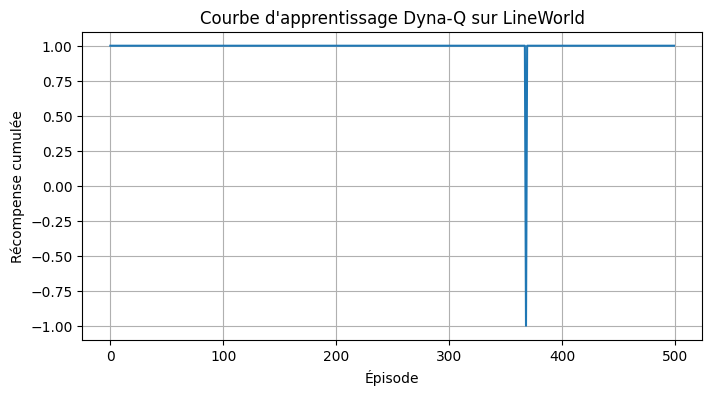

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(rewards_per_episode)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title("Courbe d'apprentissage Dyna-Q sur LineWorld")
plt.grid(True)
plt.show()

Comparaison Q(s,a) max vs V*(s) pour chaque état

In [ ]:
print('Comparaison Q(s,a) max vs V*(s) :')
for s in range(env.n_states):
    valid_actions = env.get_valid_actions(s)
    if valid_actions:
        qmax = max([Q[s][a] for a in valid_actions])
        vstar = V_opt[s]
        print(f"État {s} : Qmax={qmax:.2f} / V*={vstar:.2f} / Diff={abs(qmax-vstar):.2e}")
    else:
        print(f"État {s} : Terminal")

Comparaison Q(s,a) max vs V*(s) :
État 0 : Terminal
État 1 : Qmax=0.81 / V*=0.81 / Diff=2.33e-15
État 2 : Qmax=0.86 / V*=0.86 / Diff=1.89e-15
État 3 : Qmax=0.90 / V*=0.90 / Diff=1.44e-15
État 4 : Qmax=0.95 / V*=0.95 / Diff=8.88e-16
État 5 : Qmax=1.00 / V*=1.00 / Diff=4.44e-16
État 6 : Terminal


Statistiques exploration vs exploitation pendant l'apprentissage

In [ ]:
print(f"Nombre d'actions explorées (aléatoires) : {n_explore}")
print(f"Nombre d'actions exploitées (greedy) : {n_exploit}")
print(f"Taux d'exploration : {n_explore/(n_explore+n_exploit):.2%}")

Nombre d'actions explorées (aléatoires) : 166
Nombre d'actions exploitées (greedy) : 1492
Taux d'exploration : 10.01%


Tester différents paramètres (alpha, gamma, epsilon, n_planning)

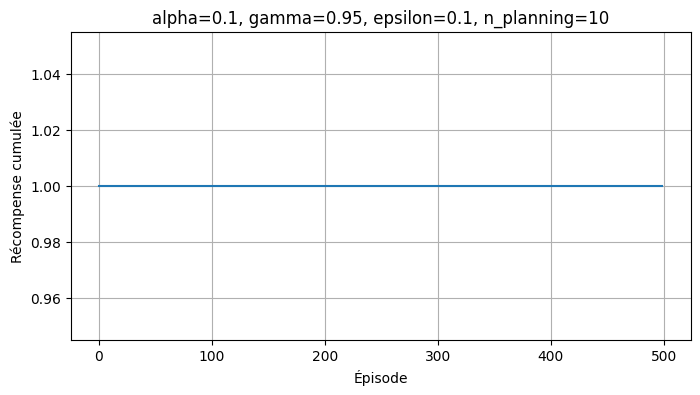

In [ ]:
# Modifie les paramètres ici pour tester leur effet
alpha = 0.1
gamma = 0.95
epsilon = 0.1
n_planning = 10
Q2, policy2, rewards2, _, _ = dyna_q(env, num_episodes=500, alpha=alpha, gamma=gamma, epsilon=epsilon, n_planning=n_planning)
plt.figure(figsize=(8,4))
plt.plot(rewards2)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title(f'alpha={alpha}, gamma={gamma}, epsilon={epsilon}, n_planning={n_planning}')
plt.grid(True)
plt.show()

Grid World

In [ ]:
from envs.grid_world.grid_world import GridWorld
import random
from collections import defaultdict
import matplotlib.pyplot as plt

Fonction Dyna-Q pour GridWorld avec statistiques exploration/exploitation

In [ ]:
def dyna_q_grid(env, num_episodes=1000, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10):
    Q = defaultdict(lambda: defaultdict(float))
    Model = defaultdict(lambda: defaultdict(lambda: None))
    visited_state_actions = set()
    rewards_per_episode = []
    n_explore = 0
    n_exploit = 0
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            valid_actions = env.get_valid_actions(state)
            if not valid_actions:
                break
            if random.random() < epsilon:
                action = random.choice(valid_actions)
                n_explore += 1
            else:
                q_values = [Q[state][a] for a in valid_actions]
                max_q = max(q_values)
                best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
                action = random.choice(best_actions)
                n_exploit += 1
            next_state, reward, done = env.step(action)
            total_reward += reward
            next_valid_actions = env.get_valid_actions(next_state)
            if next_valid_actions:
                max_next_q = max([Q[next_state][a] for a in next_valid_actions])
            else:
                max_next_q = 0.0
            Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])
            Model[state][action] = (reward, next_state)
            visited_state_actions.add((state, action))
            for _ in range(n_planning):
                s_p, a_p = random.choice(list(visited_state_actions))
                r_p, s2_p = Model[s_p][a_p]
                next_valid_actions_p = env.get_valid_actions(s2_p)
                if next_valid_actions_p:
                    max_next_q_p = max([Q[s2_p][a] for a in next_valid_actions_p])
                else:
                    max_next_q_p = 0.0
                Q[s_p][a_p] += alpha * (r_p + gamma * max_next_q_p - Q[s_p][a_p])
            state = next_state
        rewards_per_episode.append(total_reward)
    # Politique greedy
    policy = {}
    for idx in range(env.n_states):
        state = env.index_to_state(idx)
        valid_actions = env.get_valid_actions(state)
        if valid_actions:
            q_values = [Q[state][a] for a in valid_actions]
            max_q = max(q_values)
            best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
            policy[idx] = random.choice(best_actions)
        else:
            policy[idx] = -1
    return Q, policy, rewards_per_episode, n_explore, n_exploit

Entraînement Dyna-Q sur GridWorld et affichage de la politique apprise

In [ ]:
env_gw = GridWorld(n_rows=4, n_cols=4, start_state=(0,0))
Q_gw, policy_gw, rewards_gw, n_explore_gw, n_exploit_gw = dyna_q_grid(env_gw, num_episodes=1000, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10)
print("Politique apprise (flèches) :")
env_gw.render_policy(policy_gw)

Politique apprise (flèches) :
Policy visualization:
→ → → ↓
→ ↓ ↓ ↓
→ ↓ → ↓
→ → → X



Calcul et affichage de la politique optimale (Value Iteration)

In [ ]:
def value_iteration_grid(env, gamma=0.95, theta=1e-6):
    V = [0.0 for _ in range(env.n_states)]
    while True:
        delta = 0
        for idx in range(env.n_states):
            state = env.index_to_state(idx)
            if env.is_terminal(state):
                continue
            v = V[idx]
            q_values = []
            for a in env.get_valid_actions(state):
                next_state, reward, _ = env.simulate_step(state, a)
                next_idx = env.state_to_index(next_state)
                q = reward + gamma * V[next_idx]
                q_values.append(q)
            V[idx] = max(q_values)
            delta = max(delta, abs(v - V[idx]))
        if delta < theta:
            break
    # Politique optimale
    policy = {}
    for idx in range(env.n_states):
        state = env.index_to_state(idx)
        valid_actions = env.get_valid_actions(state)
        if valid_actions:
            q_values = []
            for a in valid_actions:
                next_state, reward, _ = env.simulate_step(state, a)
                next_idx = env.state_to_index(next_state)
                q = reward + gamma * V[next_idx]
                q_values.append((a, q))
            max_q = max(q_values, key=lambda x: x[1])[1]
            best_actions = [a for a, q in q_values if q == max_q]
            policy[idx] = random.choice(best_actions)
        else:
            policy[idx] = -1
    return V, policy

V_opt_gw, opt_policy_gw = value_iteration_grid(env_gw, gamma=0.95)
print("Politique optimale (flèches) :")
env_gw.render_policy(opt_policy_gw)

Politique optimale (flèches) :
Policy visualization:
↓ → → ↓
→ ↓ → ↓
↓ → → ↓
→ → → X



Comparaison automatique des politiques (apprise vs optimale)

In [ ]:
print('Comparaison des politiques :')
for idx in range(env_gw.n_states):
    pa = policy_gw[idx]
    po = opt_policy_gw[idx]
    if pa == po:
        res = 'OK'
    else:
        res = 'DIFF'
    print(f"État {env_gw.index_to_state(idx)} : apprise={pa} / optimale={po} --> {res}")

Comparaison des politiques :
État (0, 0) : apprise=3 / optimale=1 --> DIFF
État (0, 1) : apprise=3 / optimale=3 --> OK
État (0, 2) : apprise=3 / optimale=3 --> OK
État (0, 3) : apprise=1 / optimale=1 --> OK
État (1, 0) : apprise=3 / optimale=3 --> OK
État (1, 1) : apprise=1 / optimale=1 --> OK
État (1, 2) : apprise=1 / optimale=3 --> DIFF
État (1, 3) : apprise=1 / optimale=1 --> OK
État (2, 0) : apprise=3 / optimale=1 --> DIFF
État (2, 1) : apprise=1 / optimale=3 --> DIFF
État (2, 2) : apprise=3 / optimale=3 --> OK
État (2, 3) : apprise=1 / optimale=1 --> OK
État (3, 0) : apprise=3 / optimale=3 --> OK
État (3, 1) : apprise=3 / optimale=3 --> OK
État (3, 2) : apprise=3 / optimale=3 --> OK
État (3, 3) : apprise=-1 / optimale=-1 --> OK


Courbe d'apprentissage : récompense cumulée par épisode

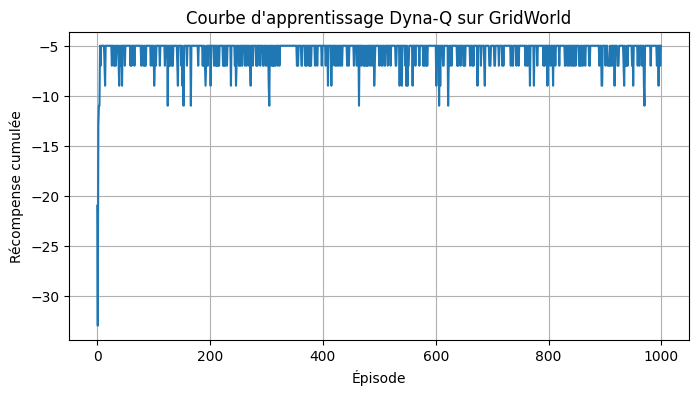

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(rewards_gw)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title("Courbe d'apprentissage Dyna-Q sur GridWorld")
plt.grid(True)
plt.show()

Comparaison Q(s,a) max vs V*(s) pour chaque état

In [ ]:
print('Comparaison Q(s,a) max vs V*(s) :')
for idx in range(env_gw.n_states):
    state = env_gw.index_to_state(idx)
    valid_actions = env_gw.get_valid_actions(state)
    if valid_actions:
        qmax = max([Q_gw[state][a] for a in valid_actions])
        vstar = V_opt_gw[idx]
        print(f"État {state} : Qmax={qmax:.2f} / V*={vstar:.2f} / Diff={abs(qmax-vstar):.2e}")
    else:
        print(f"État {state} : Terminal")

Comparaison Q(s,a) max vs V*(s) :
État (0, 0) : Qmax=-4.52 / V*=-4.52 / Diff=8.88e-15
État (0, 1) : Qmax=-3.71 / V*=-3.71 / Diff=4.88e-15
État (0, 2) : Qmax=-2.85 / V*=-2.85 / Diff=3.55e-15
État (0, 3) : Qmax=-1.95 / V*=-1.95 / Diff=1.55e-15
État (1, 0) : Qmax=-3.71 / V*=-3.71 / Diff=4.88e-15
État (1, 1) : Qmax=-2.85 / V*=-2.85 / Diff=3.55e-15
État (1, 2) : Qmax=-1.95 / V*=-1.95 / Diff=1.55e-15
État (1, 3) : Qmax=-1.00 / V*=-1.00 / Diff=4.44e-16
État (2, 0) : Qmax=-2.85 / V*=-2.85 / Diff=3.55e-15
État (2, 1) : Qmax=-1.95 / V*=-1.95 / Diff=1.55e-15
État (2, 2) : Qmax=-1.00 / V*=-1.00 / Diff=4.44e-16
État (2, 3) : Qmax=0.00 / V*=0.00 / Diff=0.00e+00
État (3, 0) : Qmax=-1.95 / V*=-1.95 / Diff=1.55e-15
État (3, 1) : Qmax=-1.00 / V*=-1.00 / Diff=4.44e-16
État (3, 2) : Qmax=0.00 / V*=0.00 / Diff=0.00e+00
État (3, 3) : Terminal


Statistiques exploration vs exploitation pendant l'apprentissage

In [ ]:
print(f"Nombre d'actions explorées (aléatoires) : {n_explore_gw}")
print(f"Nombre d'actions exploitées (greedy) : {n_exploit_gw}")
print(f"Taux d'exploration : {n_explore_gw/(n_explore_gw+n_exploit_gw):.2%}")

Nombre d'actions explorées (aléatoires) : 655
Nombre d'actions exploitées (greedy) : 6003
Taux d'exploration : 9.84%


Tester différents paramètres (alpha, gamma, epsilon, n_planning)

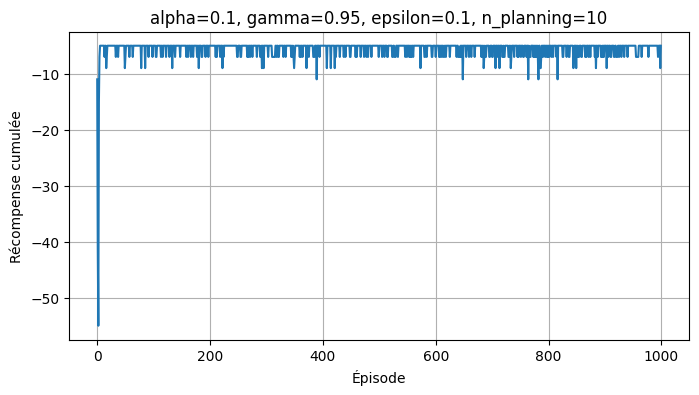

In [ ]:
# Modifie les paramètres ici pour tester leur effet
alpha = 0.1
gamma = 0.95
epsilon = 0.1
n_planning = 10
Q2_gw, policy2_gw, rewards2_gw, _, _ = dyna_q_grid(env_gw, num_episodes=1000, alpha=alpha, gamma=gamma, epsilon=epsilon, n_planning=n_planning)
plt.figure(figsize=(8,4))
plt.plot(rewards2_gw)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title(f'alpha={alpha}, gamma={gamma}, epsilon={epsilon}, n_planning={n_planning}')
plt.grid(True)
plt.show()

Monty Hall Level 1

In [ ]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Colle ici la classe MontyHallV1 si elle n'est pas déjà importée
from envs.monty_hall.monty_hall_v1 import MontyHallV1

Fonction Dyna-Q pour Monty Hall avec statistiques exploration/exploitation

In [ ]:
def dyna_q_monty(env, num_episodes=2000, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10):
    Q = defaultdict(lambda: defaultdict(float))
    Model = defaultdict(lambda: defaultdict(lambda: None))
    visited_state_actions = set()
    rewards_per_episode = []
    n_explore = 0
    n_exploit = 0
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            valid_actions = env.get_valid_actions(state)
            if not valid_actions:
                break
            if random.random() < epsilon:
                action = random.choice(valid_actions)
                n_explore += 1
            else:
                q_values = [Q[state][a] for a in valid_actions]
                max_q = max(q_values)
                best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
                action = random.choice(best_actions)
                n_exploit += 1
            next_state, reward, done = env.step(action)
            total_reward += reward
            next_valid_actions = env.get_valid_actions(next_state)
            if next_valid_actions:
                max_next_q = max([Q[next_state][a] for a in next_valid_actions])
            else:
                max_next_q = 0.0
            Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])
            Model[state][action] = (reward, next_state)
            visited_state_actions.add((state, action))
            for _ in range(n_planning):
                s_p, a_p = random.choice(list(visited_state_actions))
                r_p, s2_p = Model[s_p][a_p]
                next_valid_actions_p = env.get_valid_actions(s2_p)
                if next_valid_actions_p:
                    max_next_q_p = max([Q[s2_p][a] for a in next_valid_actions_p])
                else:
                    max_next_q_p = 0.0
                Q[s_p][a_p] += alpha * (r_p + gamma * max_next_q_p - Q[s_p][a_p])
            state = next_state
        rewards_per_episode.append(total_reward)
    # Politique greedy
    policy = {}
    for s in env.states:
        valid_actions = env.get_valid_actions(s)
        if valid_actions:
            q_values = [Q[s][a] for a in valid_actions]
            max_q = max(q_values)
            best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
            policy[s] = random.choice(best_actions)
        else:
            policy[s] = None
    return Q, policy, rewards_per_episode, n_explore, n_exploit

Entraînement Dyna-Q sur Monty Hall et affichage de la politique apprise

In [ ]:
env_mh = MontyHallV1()
Q_mh, policy_mh, rewards_mh, n_explore_mh, n_exploit_mh = dyna_q_monty(env_mh, num_episodes=2000, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10)
print("Politique apprise (état : action recommandée) :")
for s in env_mh.states:
    print(f"  État {s} : {policy_mh[s]}")

Politique apprise (état : action recommandée) :
  État (0, -1, -1) : 0
  État (1, 0, 1) : 0
  État (1, 0, 2) : 0
  État (1, 1, 0) : 0
  État (1, 1, 2) : 0
  État (1, 2, 0) : 1
  État (1, 2, 1) : 1
  État (2, 0, -1) : None
  État (2, 1, -1) : None
  État (2, 2, -1) : None


Politique optimale (calcul analytique)

In [ ]:
# Pour Monty Hall classique, la politique optimale est :
# - Étape 0 : choisir n'importe quelle porte (équivalent)
# - Étape 1 : toujours switcher (action 1)
opt_policy_mh = {}
for s in env_mh.states:
    step, chosen, remaining = s
    if step == 0:
        opt_policy_mh[s] = 0  # ou 1 ou 2, équivalent
    elif step == 1:
        opt_policy_mh[s] = 1  # switch
    else:
        opt_policy_mh[s] = None
print("Politique optimale (état : action optimale) :")
for s in env_mh.states:
    print(f"  État {s} : {opt_policy_mh[s]}")

Politique optimale (état : action optimale) :
  État (0, -1, -1) : 0
  État (1, 0, 1) : 1
  État (1, 0, 2) : 1
  État (1, 1, 0) : 1
  État (1, 1, 2) : 1
  État (1, 2, 0) : 1
  État (1, 2, 1) : 1
  État (2, 0, -1) : None
  État (2, 1, -1) : None
  État (2, 2, -1) : None


Comparaison automatique des politiques (apprise vs optimale)

In [ ]:
print('Comparaison des politiques :')
for s in env_mh.states:
    pa = policy_mh[s]
    po = opt_policy_mh[s]
    if pa == po:
        res = 'OK'
    else:
        res = 'DIFF'
    print(f"État {s} : apprise={pa} / optimale={po} --> {res}")

Comparaison des politiques :
État (0, -1, -1) : apprise=0 / optimale=0 --> OK
État (1, 0, 1) : apprise=0 / optimale=1 --> DIFF
État (1, 0, 2) : apprise=0 / optimale=1 --> DIFF
État (1, 1, 0) : apprise=0 / optimale=1 --> DIFF
État (1, 1, 2) : apprise=0 / optimale=1 --> DIFF
État (1, 2, 0) : apprise=1 / optimale=1 --> OK
État (1, 2, 1) : apprise=1 / optimale=1 --> OK
État (2, 0, -1) : apprise=None / optimale=None --> OK
État (2, 1, -1) : apprise=None / optimale=None --> OK
État (2, 2, -1) : apprise=None / optimale=None --> OK


Courbe d'apprentissage : récompense cumulée par épisode

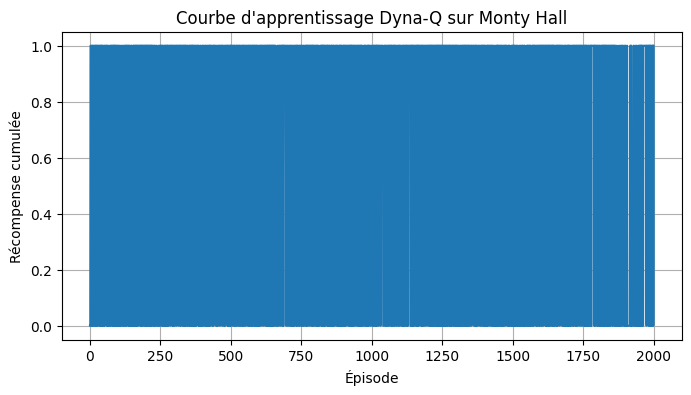

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(rewards_mh)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title("Courbe d'apprentissage Dyna-Q sur Monty Hall")
plt.grid(True)
plt.show()

Statistiques exploration vs exploitation pendant l'apprentissage

In [ ]:
print(f"Nombre d'actions explorées (aléatoires) : {n_explore_mh}")
print(f"Nombre d'actions exploitées (greedy) : {n_exploit_mh}")
print(f"Taux d'exploration : {n_explore_mh/(n_explore_mh+n_exploit_mh):.2%}")

Nombre d'actions explorées (aléatoires) : 415
Nombre d'actions exploitées (greedy) : 3585
Taux d'exploration : 10.38%


Tester différents paramètres (alpha, gamma, epsilon, n_planning)

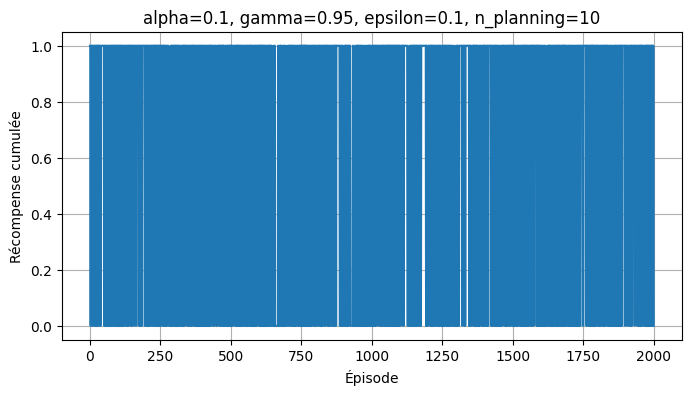

In [ ]:
# Modifie les paramètres ici pour tester leur effet
alpha = 0.1
gamma = 0.95
epsilon = 0.1
n_planning = 10
Q2_mh, policy2_mh, rewards2_mh, _, _ = dyna_q_monty(env_mh, num_episodes=2000, alpha=alpha, gamma=gamma, epsilon=epsilon, n_planning=n_planning)
plt.figure(figsize=(8,4))
plt.plot(rewards2_mh)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title(f'alpha={alpha}, gamma={gamma}, epsilon={epsilon}, n_planning={n_planning}')
plt.grid(True)
plt.show()

Monty Hall Level 2

In [ ]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Colle ici la classe MontyHallV2 si elle n'est pas déjà importée
from envs.monty_hall.monty_hall_v2 import MontyHallV2

Fonction Dyna-Q pour Monty Hall Level 2 avec statistiques exploration/exploitation

In [ ]:
def dyna_q_monty_v2(env, num_episodes=3000, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10):
    Q = defaultdict(lambda: defaultdict(float))
    Model = defaultdict(lambda: defaultdict(lambda: None))
    visited_state_actions = set()
    rewards_per_episode = []
    n_explore = 0
    n_exploit = 0
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            valid_actions = env.get_valid_actions(state)
            if not valid_actions:
                break
            if random.random() < epsilon:
                action = random.choice(valid_actions)
                n_explore += 1
            else:
                q_values = [Q[state][a] for a in valid_actions]
                max_q = max(q_values)
                best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
                action = random.choice(best_actions)
                n_exploit += 1
            next_state, reward, done = env.step(action)
            total_reward += reward
            next_valid_actions = env.get_valid_actions(next_state)
            if next_valid_actions:
                max_next_q = max([Q[next_state][a] for a in next_valid_actions])
            else:
                max_next_q = 0.0
            Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])
            Model[state][action] = (reward, next_state)
            visited_state_actions.add((state, action))
            for _ in range(n_planning):
                s_p, a_p = random.choice(list(visited_state_actions))
                r_p, s2_p = Model[s_p][a_p]
                next_valid_actions_p = env.get_valid_actions(s2_p)
                if next_valid_actions_p:
                    max_next_q_p = max([Q[s2_p][a] for a in next_valid_actions_p])
                else:
                    max_next_q_p = 0.0
                Q[s_p][a_p] += alpha * (r_p + gamma * max_next_q_p - Q[s_p][a_p])
            state = next_state
        rewards_per_episode.append(total_reward)
    # Politique greedy
    policy = {}
    for s in env.states:
        valid_actions = env.get_valid_actions(s)
        if valid_actions:
            q_values = [Q[s][a] for a in valid_actions]
            max_q = max(q_values)
            best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
            policy[s] = random.choice(best_actions)
        else:
            policy[s] = None
    return Q, policy, rewards_per_episode, n_explore, n_exploit

Entraînement Dyna-Q sur Monty Hall Level 2 et affichage de la politique apprise

In [ ]:
env_mh2 = MontyHallV2(n_doors=5)
Q_mh2, policy_mh2, rewards_mh2, n_explore_mh2, n_exploit_mh2 = dyna_q_monty_v2(env_mh2, num_episodes=3000, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10)
print("Politique apprise (état : action recommandée) :")
for s in env_mh2.states[:10]:  # Affiche les 10 premiers états pour lisibilité
    print(f"  État {s} : {policy_mh2[s]}")
print("... (affichage tronqué)")

Politique apprise (état : action recommandée) :
  État (0, (0, 1, 2, 3, 4), -1) : 2
  État (1, (0, 2, 3, 4), 0) : 0
  État (1, (0, 1, 3, 4), 0) : 1
  État (1, (0, 1, 2, 4), 0) : 1
  État (1, (0, 1, 2, 3), 0) : 0
  État (1, (0, 1, 3, 4), 1) : 0
  État (1, (0, 1, 2, 4), 1) : 2
  État (1, (0, 1, 2, 3), 1) : 3
  État (1, (1, 2, 3, 4), 1) : 3
  État (1, (0, 2, 3, 4), 2) : 0
... (affichage tronqué)


Politique optimale (stratégie : toujours switcher)

In [ ]:
# Pour Monty Hall généralisé, la stratégie optimale est de toujours switcher à chaque étape
opt_policy_mh2 = {}
for s in env_mh2.states:
    step, doors_remaining, last_chosen = s
    if env_mh2.is_terminal(s):
        opt_policy_mh2[s] = None
    else:
        # Toujours choisir une porte différente de la précédente si possible
        # (switcher)
        for a in env_mh2.get_valid_actions(s):
            if a != last_chosen:
                opt_policy_mh2[s] = a
                break
        else:
            opt_policy_mh2[s] = last_chosen  # fallback
print("Politique optimale (état : action optimale) :")
for s in env_mh2.states[:10]:
    print(f"  État {s} : {opt_policy_mh2[s]}")
print("... (affichage tronqué)")

Politique optimale (état : action optimale) :
  État (0, (0, 1, 2, 3, 4), -1) : 0
  État (1, (0, 2, 3, 4), 0) : 2
  État (1, (0, 1, 3, 4), 0) : 1
  État (1, (0, 1, 2, 4), 0) : 1
  État (1, (0, 1, 2, 3), 0) : 1
  État (1, (0, 1, 3, 4), 1) : 0
  État (1, (0, 1, 2, 4), 1) : 0
  État (1, (0, 1, 2, 3), 1) : 0
  État (1, (1, 2, 3, 4), 1) : 2
  État (1, (0, 2, 3, 4), 2) : 0
... (affichage tronqué)


Comparaison automatique des politiques (apprise vs optimale)

In [ ]:
print('Comparaison des politiques (10 premiers états) :')
for s in env_mh2.states[:10]:
    pa = policy_mh2[s]
    po = opt_policy_mh2[s]
    if pa == po:
        res = 'OK'
    else:
        res = 'DIFF'
    print(f"État {s} : apprise={pa} / optimale={po} --> {res}")
print("... (affichage tronqué)")

Comparaison des politiques (10 premiers états) :
État (0, (0, 1, 2, 3, 4), -1) : apprise=2 / optimale=0 --> DIFF
État (1, (0, 2, 3, 4), 0) : apprise=0 / optimale=2 --> DIFF
État (1, (0, 1, 3, 4), 0) : apprise=1 / optimale=1 --> OK
État (1, (0, 1, 2, 4), 0) : apprise=1 / optimale=1 --> OK
État (1, (0, 1, 2, 3), 0) : apprise=0 / optimale=1 --> DIFF
État (1, (0, 1, 3, 4), 1) : apprise=0 / optimale=0 --> OK
État (1, (0, 1, 2, 4), 1) : apprise=2 / optimale=0 --> DIFF
État (1, (0, 1, 2, 3), 1) : apprise=3 / optimale=0 --> DIFF
État (1, (1, 2, 3, 4), 1) : apprise=3 / optimale=2 --> DIFF
État (1, (0, 2, 3, 4), 2) : apprise=0 / optimale=0 --> OK
... (affichage tronqué)


Courbe d'apprentissage : récompense cumulée par épisode

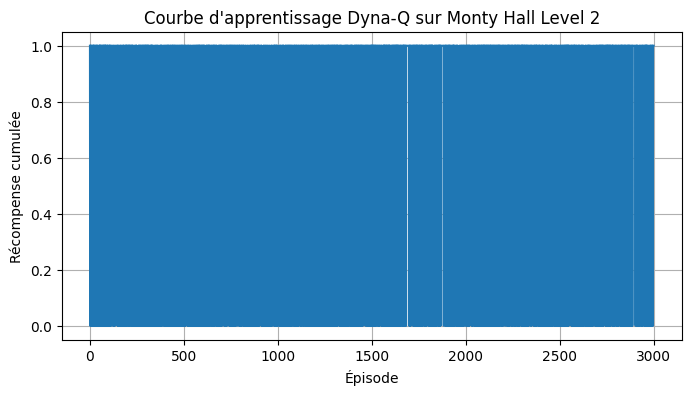

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(rewards_mh2)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title("Courbe d'apprentissage Dyna-Q sur Monty Hall Level 2")
plt.grid(True)
plt.show()

Statistiques exploration vs exploitation pendant l'apprentissage

In [ ]:
print(f"Nombre d'actions explorées (aléatoires) : {n_explore_mh2}")
print(f"Nombre d'actions exploitées (greedy) : {n_exploit_mh2}")
print(f"Taux d'exploration : {n_explore_mh2/(n_explore_mh2+n_exploit_mh2):.2%}")

Nombre d'actions explorées (aléatoires) : 1169
Nombre d'actions exploitées (greedy) : 10831
Taux d'exploration : 9.74%


Tester différents paramètres (alpha, gamma, epsilon, n_planning)

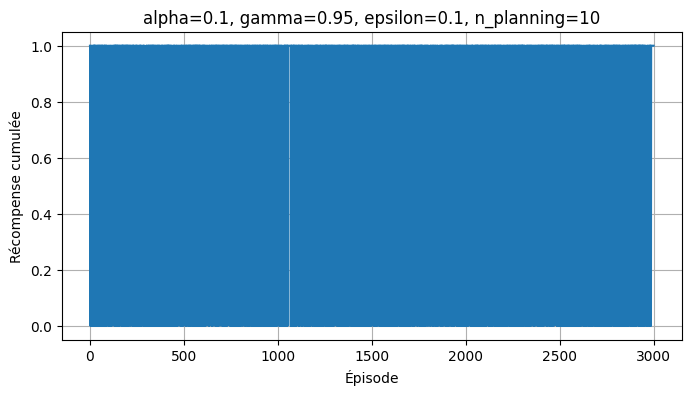

In [ ]:
# Modifie les paramètres ici pour tester leur effet
alpha = 0.1
gamma = 0.95
epsilon = 0.1
n_planning = 10
Q2_mh2, policy2_mh2, rewards2_mh2, _, _ = dyna_q_monty_v2(env_mh2, num_episodes=3000, alpha=alpha, gamma=gamma, epsilon=epsilon, n_planning=n_planning)
plt.figure(figsize=(8,4))
plt.plot(rewards2_mh2)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title(f'alpha={alpha}, gamma={gamma}, epsilon={epsilon}, n_planning={n_planning}')
plt.grid(True)
plt.show()

Two round Rock Paper Scissors

In [ ]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Colle ici la classe TwoRoundRPS si elle n'est pas déjà importée
from envs.rps.two_round_rps import TwoRoundRPS

Fonction Dyna-Q pour Two-Round RPS avec statistiques exploration/exploitation

In [ ]:
def dyna_q_rps(env, num_episodes=2000, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10):
    Q = defaultdict(lambda: defaultdict(float))
    Model = defaultdict(lambda: defaultdict(lambda: None))
    visited_state_actions = set()
    rewards_per_episode = []
    n_explore = 0
    n_exploit = 0
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            valid_actions = env.get_valid_actions(state)
            if not valid_actions:
                break
            if random.random() < epsilon:
                action = random.choice(valid_actions)
                n_explore += 1
            else:
                q_values = [Q[state][a] for a in valid_actions]
                max_q = max(q_values)
                best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
                action = random.choice(best_actions)
                n_exploit += 1
            next_state, reward, done = env.step(action)
            total_reward += reward
            next_valid_actions = env.get_valid_actions(next_state)
            if next_valid_actions:
                max_next_q = max([Q[next_state][a] for a in next_valid_actions])
            else:
                max_next_q = 0.0
            Q[state][action] += alpha * (reward + gamma * max_next_q - Q[state][action])
            Model[state][action] = (reward, next_state)
            visited_state_actions.add((state, action))
            for _ in range(n_planning):
                s_p, a_p = random.choice(list(visited_state_actions))
                r_p, s2_p = Model[s_p][a_p]
                next_valid_actions_p = env.get_valid_actions(s2_p)
                if next_valid_actions_p:
                    max_next_q_p = max([Q[s2_p][a] for a in next_valid_actions_p])
                else:
                    max_next_q_p = 0.0
                Q[s_p][a_p] += alpha * (r_p + gamma * max_next_q_p - Q[s_p][a_p])
            state = next_state
        rewards_per_episode.append(total_reward)
    # Politique greedy
    policy = {}
    for s in env.states:
        valid_actions = env.get_valid_actions(s)
        if valid_actions:
            q_values = [Q[s][a] for a in valid_actions]
            max_q = max(q_values)
            best_actions = [a for a, q in zip(valid_actions, q_values) if q == max_q]
            policy[s] = random.choice(best_actions)
        else:
            policy[s] = None
    return Q, policy, rewards_per_episode, n_explore, n_exploit

Entraînement Dyna-Q sur Two-Round RPS et affichage de la politique apprise

In [ ]:
env_rps = TwoRoundRPS()
Q_rps, policy_rps, rewards_rps, n_explore_rps, n_exploit_rps = dyna_q_rps(env_rps, num_episodes=2000, alpha=0.1, gamma=0.95, epsilon=0.1, n_planning=10)
print("Politique apprise (état : action recommandée) :")
for s in env_rps.states:
    print(f"  État {s} : {policy_rps[s]}")

Politique apprise (état : action recommandée) :
  État (0, -1) : 2
  État (1, 0) : 1
  État (1, 1) : 2
  État (1, 2) : 0
  État (2, 0) : None
  État (2, 1) : None
  État (2, 2) : None


Politique optimale (stratégie théorique)

In [ ]:
# Pour Two-Round RPS, la stratégie optimale dépend de l'adversaire.
# Ici, on affiche la politique qui maximise l'espérance contre l'adversaire décrit (aléatoire puis copie).
# Pour le premier round, tout est équivalent. Pour le second, jouer ce qui bat le premier coup.
opt_policy_rps = {}
for s in env_rps.states:
    round_id, my_first_move = s
    if round_id == 0:
        opt_policy_rps[s] = 0  # ou 1 ou 2, équivalent
    elif round_id == 1:
        # L'adversaire va copier le premier coup, donc il faut jouer ce qui bat ce coup
        if my_first_move == 0:
            opt_policy_rps[s] = 1  # Paper bat Rock
        elif my_first_move == 1:
            opt_policy_rps[s] = 2  # Scissors bat Paper
        elif my_first_move == 2:
            opt_policy_rps[s] = 0  # Rock bat Scissors
        else:
            opt_policy_rps[s] = 0
    else:
        opt_policy_rps[s] = None
print("Politique optimale (état : action optimale) :")
for s in env_rps.states:
    print(f"  État {s} : {opt_policy_rps[s]}")

Politique optimale (état : action optimale) :
  État (0, -1) : 0
  État (1, 0) : 1
  État (1, 1) : 2
  État (1, 2) : 0
  État (2, 0) : None
  État (2, 1) : None
  État (2, 2) : None


Comparaison automatique des politiques (apprise vs optimale)

In [ ]:
print('Comparaison des politiques :')
for s in env_rps.states:
    pa = policy_rps[s]
    po = opt_policy_rps[s]
    if pa == po:
        res = 'OK'
    else:
        res = 'DIFF'
    print(f"État {s} : apprise={pa} / optimale={po} --> {res}")

Comparaison des politiques :
État (0, -1) : apprise=2 / optimale=0 --> DIFF
État (1, 0) : apprise=1 / optimale=1 --> OK
État (1, 1) : apprise=2 / optimale=2 --> OK
État (1, 2) : apprise=0 / optimale=0 --> OK
État (2, 0) : apprise=None / optimale=None --> OK
État (2, 1) : apprise=None / optimale=None --> OK
État (2, 2) : apprise=None / optimale=None --> OK


Courbe d'apprentissage : récompense cumulée par épisode

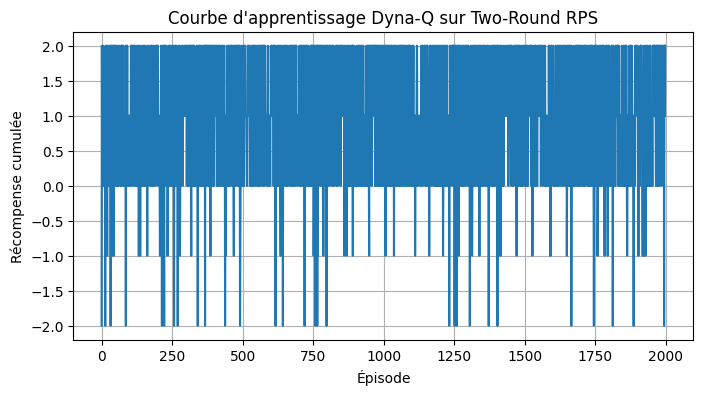

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(rewards_rps)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title("Courbe d'apprentissage Dyna-Q sur Two-Round RPS")
plt.grid(True)
plt.show()

Statistiques exploration vs exploitation pendant l'apprentissage

In [ ]:
print(f"Nombre d'actions explorées (aléatoires) : {n_explore_rps}")
print(f"Nombre d'actions exploitées (greedy) : {n_exploit_rps}")
print(f"Taux d'exploration : {n_explore_rps/(n_explore_rps+n_exploit_rps):.2%}")

Nombre d'actions explorées (aléatoires) : 431
Nombre d'actions exploitées (greedy) : 3569
Taux d'exploration : 10.78%


Tester différents paramètres (alpha, gamma, epsilon, n_planning)

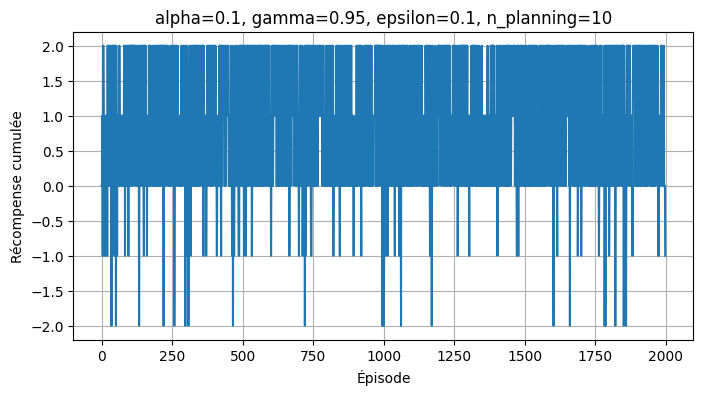

In [ ]:
# Modifie les paramètres ici pour tester leur effet
alpha = 0.1
gamma = 0.95
epsilon = 0.1
n_planning = 10
Q2_rps, policy2_rps, rewards2_rps, _, _ = dyna_q_rps(env_rps, num_episodes=2000, alpha=alpha, gamma=gamma, epsilon=epsilon, n_planning=n_planning)
plt.figure(figsize=(8,4))
plt.plot(rewards2_rps)
plt.xlabel('Épisode')
plt.ylabel('Récompense cumulée')
plt.title(f'alpha={alpha}, gamma={gamma}, epsilon={epsilon}, n_planning={n_planning}')
plt.grid(True)
plt.show()

Fin